## Main

### Import Required Packages

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

### Camera Calibration

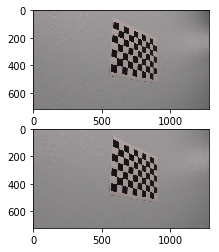

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print(objp)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
grayimages=[]
imageslist=[]
i=0
for fname in images:
    img = cv2.imread(fname)
    if(img.shape[0]>720):
        img.resize((720,1280,3))
    grayimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayimg, (9,6),None)
    if (ret == True):
        imageslist.append(img)
        grayimages.append(grayimg)
        imgpoints.append(corners)
        objpoints.append(objp)
        img2 = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayimg.shape[::-1], None, None)

Calib_Mat = [mtx,dist]
pickle.dump(Calib_Mat,open("Calib_Mat.p",'wb'))

for fname in images:
    img=cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(1)
    plt.subplot(211)
    plt.imshow(img)
    plt.subplot(212)
    plt.imshow(dst)
    p1=fname.split('\\')
    p2=p1[1].split('.')
    #plt.savefig('undistorted_images\\' + (p2[0]) + '.png')    

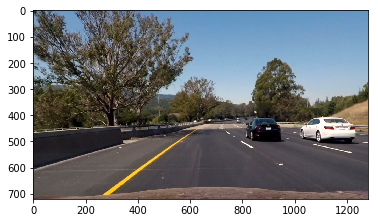

In [9]:
images = glob.glob('test_images\straight_lines*.jpg')
[mtx,dist] = pickle.load(open('Calib_Mat.p','rb'))
for fname in images:
    img = cv2.imread(fname)
    img_u = undistort_image_frame(img,mtx,dist)
    p1=fname.split('\\')
    p2=p1[1].split('.')
    plt.imshow(cv2.cvtColor(img_u,cv2.COLOR_BGR2RGB))
    plt.savefig('test_images\\undistorted_out\\' + (p2[0]) + '.png')

## Function Definitions

In [3]:
# step 1 = Undistort Images

def undistort_image_frame(img,mtx,dist):
    
    return cv2.undistort(img, mtx, dist, None, mtx)
    
def sobel_thresh(img, orient ='x', thresh_min = 20, thresh_max = 100, sobel_kernel = 3):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx= np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
    sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1
    if orient == 'x':
        return sxbinary, sobelx, sobely
    if orient == 'y':
        return sybinary, sobelx, sobely
    
def mag_thresh(img, sobel_kernel =3, mag_thresh_min= 20, mag_thresh_max =100, thresh_min=20, thresh_max=100):
    [temp, sobelx, sobely] = sobel_thresh(img, 'x', thresh_min, thresh_max, sobel_kernel )
    sobelxy = np.sqrt(sobelx**2,sobely**2)
    scalefactor = np.max(sobelxy)/255
    scaled_sobelxy = (sobelxy/scalefactor).astype(np.uint8) 
    sxbinary = np.zeros_like(scaled_sobelxy)
    sxbinary[(scaled_sobelxy >= mag_thresh_min) & (scaled_sobelxy <= mag_thresh_max)] = 1
    return sxbinary, sobelx, sobely

def dir_threshold(img, sobel_kernel= 3, thresh=(0, np.pi/2)):
    [temp, sobelx,sobely ] = sobel_thresh(img, 'x', 35, 150, 3)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    #L = L*(255/np.max(L))
    threshL =(120,255)
    threshS = (120, 255)
    binary = np.zeros_like(S)
    binary[((S > threshS[0]) & (S <= threshS[1]) )&((L > threshL[0]) & (L <= threshL[1]) )] = 1
    return binary

def combine_thresholds(img):
    [sx,temp1,temp2] = sobel_thresh(img,'x',35,200)
    [sy,temp1,temp2] = sobel_thresh(img,'y',35,200)
    [m_sx,temp1,temp2] = mag_thresh(img,3,30,255, 35, 150)
    dir_bin = dir_threshold(img,3,(0.8,1.08))
    hls_bin = hls_thresh(img)
    combined = np.zeros_like(dir_bin)
    combined[(((sx == 1)) | ((m_sx == 1) & (dir_bin == 1)) | (hls_bin ==1))] = 1
    return combined

def p_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[200, 720],
        [1100, 720],
        [595, 450],
        [685, 450]])
    dst = np.float32(
        [[300, 720],
        [980, 720],
        [300, 0],
        [980, 0]])
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, m_inv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, unwarped, m, m_inv
    
def find_hist(img, win_y_low = None, win_y_high = 520):
    if win_y_low == None:
        win_y_low = img.shape[0]
    else:
        win_y_low=img.shape[0]
        win_y_high = 0
        
    histogram = np.sum(img[win_y_high:,:],axis=0)
    return histogram

def fit_poly(img, nwindows = 9):
    histogram = find_hist(img)
    out_img = np.dstack((img,img,img))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(img.shape[0]/nwindows)
        
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        #print(out_img.shape)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        if (len(good_left_inds) ==0 | len(good_right_inds ==0)):
            hist_temp=find_hist(img[win_y_low:win_y_high,:])
            leftx_current = np.argmax(hist_temp[:midpoint])
            rightx_current = np.argmax(hist_temp[midpoint:]) + midpoint
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print(len(left_lane_inds))
    plt.imshow(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    return [out_img, left_fitx,right_fitx, ploty] , [leftx, lefty, rightx, righty], [left_lane_inds, right_lane_inds, nonzerox, nonzeroy]
    
def find_curvature(img,lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    nonzerox = lane_inds[2]
    nonzeroy = lane_inds[3]
    left_lane_inds = lane_inds[0]
    right_lane_inds = lane_inds[1]
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    y_eval = (img.shape[0]-1)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

def Avg_Cache(cache):
    new_out1 = np.mean(cache['out1'],axis=0)
    new_out2 = np.mean(cache['out2'],axis=0)
    new_out3 = np.mean(cache['out3'],axis=0)
    
    return [new_out1,new_out2,new_out3]

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def main_pipeline(img, video_process = True):
    if video_process == True:
        global Frame
        global cache
        global Stack_Counter
        Stack_Counter =1
    # Load pickle file for Distortion Matrix
    [mtx,dist] = pickle.load(open('Calib_Mat.p','rb'))
    #print(np.asarray(img.shape))
    if np.asarray(img).shape[0] is not 720:
        img= cv2.resize(img,(1280,720))
        #print(np.asarray(img.shape))
    # Return Undistorated Image
    c_img = region_of_interest(img,np.array( [[[190,img.shape[0]],[450,400],[700,420],[750 ,400],[1200,img.shape[0]]]], dtype=np.int32 ))

    U_img= undistort_image_frame(c_img,mtx,dist)

    # Perform Thresholds
    combined_thresh_img = combine_thresholds(U_img)

    # Perform Perspective Transform
    warped, unwarped, m, m_inv = p_transform(combined_thresh_img)
    try:
        # FitPolynomial to lines
        [out_img,line_pixel_pos,lane_inds]=fit_poly(warped)
        
        #Calculate Curvature
        #print(np.asarray(lane_inds[3]).shape)
        find_curvature(img,lane_inds)
        #print(lane_inds[0].shape)
        if video_process == True:
            if Frame <= 2:
                cache['out1'].append(out_img[1])
                cache['out2'].append(out_img[2])
                cache['out3'].append(out_img[3])
            if Frame > 2:
                #print(np.asarray(out_img[1]).shape,np.asarray(out_img[2]).shape,np.asarray(out_img[3]).shape, Frame-(5*Stack_Counter))
                #print('p',np.asarray(cache['out1']).shape)
                cache['out1'].pop(0)
                cache['out1'].append(out_img[1])
                cache['out2'].pop(0)
                cache['out2'].append(out_img[2])
                cache['out3'].pop(0)
                cache['out3'].append(out_img[3])
                #print('p',np.asarray(cache['out1']).shape)
            Stack_Counter+=1
            Frame +=1
    except ValueError:
        print(ValueError)
        print('no polyfit detected')
    
    New_out_img = Avg_Cache(cache)

    if video_process == False:
        New_out_img[0]=out_img[1]
        New_out_img[1]=out_img[2]
        New_out_img[2]=out_img[3]

        #print(np.asarray(New_out_img[0]).shape,np.asarray(New_out_img[1]).shape)
    left_line = np.hstack(((np.array([np.transpose(np.vstack([New_out_img[0]+20, New_out_img[2]]))])),(np.array([np.flipud(np.transpose(np.vstack([New_out_img[0]-10, New_out_img[2]])))]))))
    right_line = np.hstack(((np.array([np.transpose(np.vstack([New_out_img[1]+20, New_out_img[2]]))])),(np.array([np.flipud(np.transpose(np.vstack([New_out_img[1]-10, New_out_img[2]])))]))))

    window_leftEdge = np.array([np.transpose(np.vstack([New_out_img[0], New_out_img[2]]))])
    window_rightEdge = np.array([np.flipud(np.transpose(np.vstack([New_out_img[1], New_out_img[2]])))])
    windowPTs = np.hstack((window_leftEdge, window_rightEdge))


    final_image=(np.dstack((warped, warped, warped))*255).astype('uint8')
    cv2.fillPoly(final_image, np.int_([windowPTs]), (0,255, 0))
    cv2.fillPoly(final_image, np.int_([left_line]), (255,0, 0))
    cv2.fillPoly(final_image, np.int_([right_line]), (255,0, 0))
    #plt.imshow(final_image)

    #plt.plot(out_img[1], out_img[3], color='red', linewidth=7.0)
    #plt.plot(out_img[2], out_img[3], color='red', linewidth=7.0)
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    unwarped_f= cv2.warpPerspective(final_image, m_inv, (img.shape[1], img.shape[0]))
    if video_process == False:
        return [cv2.cvtColor(cv2.addWeighted(unwarped_f,0.5,img,1,0),cv2.COLOR_BGR2RGB), out_img]
        #return c_img
    else:
        return cv2.addWeighted(unwarped_f,0.5,img,1,0)

        
print('done')

done


## Pipeline

43595


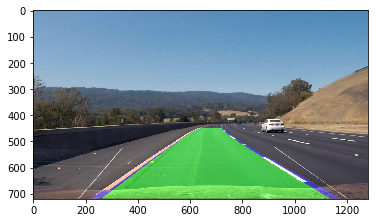

In [4]:
global Frame,Stack_Counter,cache
Frame =1
Stack_Counter=1
cache=defaultdict(list)
img = cv2.imread('test_images\straight_lines5.jpg')
[final_image,out_img]=main_pipeline(img, False)
plt.imshow(final_image)
#p1=fname.split('\\')
#p2=p1[1].split('.')
#plt.savefig('test_images\\final\\' + (p2[0]) + '.png')

    


### Run Sobel on test images

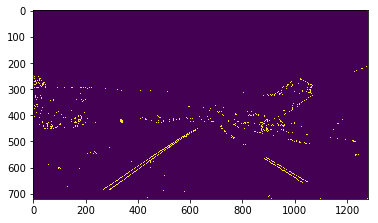

In [5]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines5.jpg')
[sx,temp1,temp2] = sobel_thresh(img,'x',35,150)
#p1=fname.split('\\')
#p2=p1[1].split('.')
plt.imshow(sx)
#plt.savefig('test_images\\Sobel_out\\' + (p2[0]) + '.png')

### Run Mag Threshold on test images

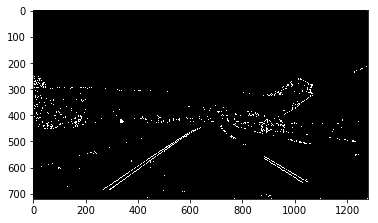

In [6]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines5.jpg')
[sx,temp1,temp2] = mag_thresh(img,3,30,255, 35, 150)
#p1=fname.split('\\')
#p2=p1[1].split('.')
plt.imshow(sx, cmap='gray')
#plt.savefig('test_images\\mag_out\\' + (p2[0]) + '.png')

### Run Direction Gradient Threshold on test Images

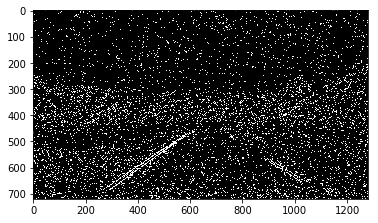

In [7]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines5.jpg')
sx = dir_threshold(img,3,(0.8,1.08))
#p1=fname.split('\\')
#p2=p1[1].split('.')
plt.imshow(sx, cmap='gray')
#plt.savefig('test_images\\dir_out\\' + (p2[0]) + '.png')
    

### Run HLS Thresh

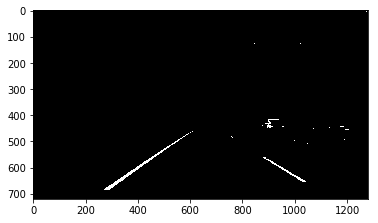

In [8]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines5.jpg')
sx = hls_thresh(img)
#p1=fname.split('\\')
#p2=p1[1].split('.')
plt.imshow(sx, cmap='gray')
#plt.savefig('test_images\\hls_out\\' + (p2[0]) + '.png')

### Run Combined

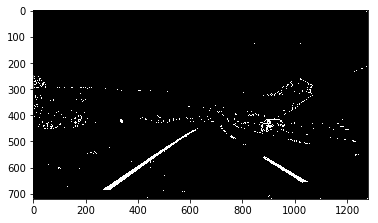

In [9]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines5.jpg')
sx = combine_thresholds(img)
#p1=fname.split('\\')
#p2=p1[1].split('.')
plt.imshow(sx, cmap='gray')
#plt.savefig('test_images\\combined_out\\' + (p2[0]) + '.png')


### Run Perspective transform

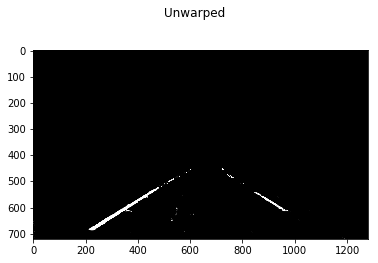

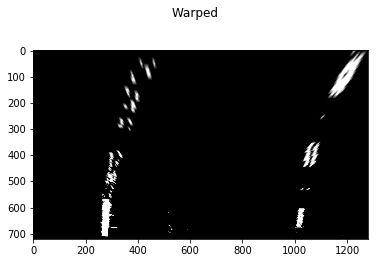

In [12]:
#images = glob.glob('test_images\straight_lines*.jpg')
#for fname in images:
img = cv2.imread('test_images\straight_lines7.jpg')
combined_thresh_img=combine_thresholds(img)
warped, unwarped, m, m_inv = p_transform(combined_thresh_img)
#p1=fname.split('\\')
#p2=p1[1].split('.')
fig=plt.figure()
fig.suptitle('Unwarped')
plt.imshow(unwarped, cmap='gray')
#plt.savefig('test_images\\p_transform_out\\unwarped\\' + (p2[0]) + '_unwarped.png')
fig=plt.figure()
fig.suptitle('Warped')
plt.imshow(warped, cmap='gray')
#plt.savefig('test_images\\p_transform_out\\warped\\' + (p2[0]) + '_warped.png')


### Run Hist on Perspective of Single Image

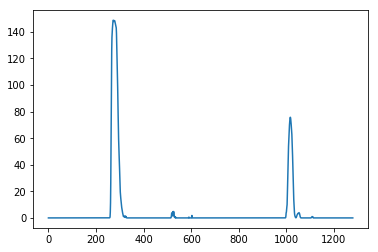

In [10]:

img = cv2.imread('test_images\straight_lines7.jpg')
[mtx,dist] = pickle.load(open('Calib_Mat.p','rb'))
U_img= undistort_image_frame(img,mtx,dist)
combined_thresh_img = combine_thresholds(U_img)
warped, unwarped, m, m_inv = p_transform(combined_thresh_img)
hist = find_hist(warped)
p1=fname.split('\\')
p2=p1[1].split('.')
plt.plot(hist)



### Run Hist on Perspective of All Images

40960


TypeError: img is not a numpy array, neither a scalar

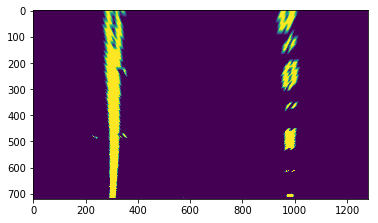

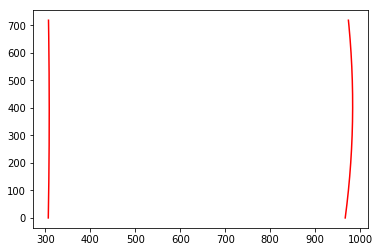

In [7]:
def plot_poly_fit(warped,fname,  savefig = False):
    [out_img,line_pixel_pos,temp]=fit_poly(warped)
    plt.gcf().clear()
    plt.imshow(warped)
    left_fitx = out_img[1]
    right_fitx= out_img[2]
    ploty=out_img[3]
    fig=plt.figure()
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    if savefig == True:
        p1=fname.split('\\')
        p2=p1[1].split('.')
        #plt.savefig('test_images\\Lanes\\' + (p2[0]) + '.png')
    
    
images = glob.glob('test_images\straight_lines*.jpg')
for fname in images:
    img = cv2.imread(fname)
    [mtx,dist] = pickle.load(open('Calib_Mat.p','rb'))
    U_img= undistort_image_frame(img,mtx,dist)
    combined_thresh_img = combine_thresholds(U_img)
    warped, unwarped, m, m_inv = p_transform(combined_thresh_img)
    plot_poly_fit(warped,fname)
    font = cv2.FONT_HERSHEY_TRIPLEX
    
        


### On final Video

### Run Main_JNB2 to view video code.
